# `fMRI-01`: Modeling the hemodynamic response
Today's demonstration will introduce programmatic implementations of the hemodynamic response function (HRF). We will cover the canonical double gamma model, as well as other variants introduced in the literature.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

### The double-gamma HRF
Much like the action potential, the canonical hemodynamic response has two distinct phases: a initial rising phase and a subsequent prolonged undershoot. In general, the rising phase peaks around 6 s and the trough of the undershoot occurs around 16 s. 

Traditionally, the shape of the HRF is modeled by the superposition of two **[gamma distributions](https://en.wikipedia.org/wiki/Gamma_distribution)**. The gamma distribution can be defined according to several different parameterizations. Here, we will define gamma according to its mode and variance. The mode defines the center of the probability mass of the distribution, whereas the variance describes the dispersion around the mean. 

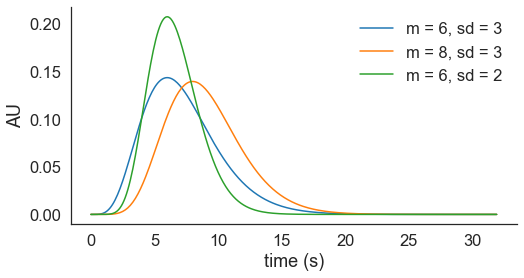

In [2]:
from fmritools.hrf import gamma_mode_pdf

# Define time series
times = np.arange(0, 32, 0.1)

# Evaluate the PDF
pdf_1 = gamma_mode_pdf(times, 6, 3)
pdf_2 = gamma_mode_pdf(times, 8, 3)
pdf_3 = gamma_mode_pdf(times, 6, 2)

# Plot example gammas
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(times, pdf_1, label='m = 6, sd = 3')
ax.plot(times, pdf_2, label='m = 8, sd = 3')
ax.plot(times, pdf_3, label='m = 6, sd = 2')
ax.set(xlabel='time (s)', ylabel='AU')
ax.legend(loc=1, frameon=False)
sns.despine()

Note the difference in shape between the gamma and normal distributions. Whereas the normal distribution is symmetric (i.e. the left and right tails are identical), the gamma distribution is right-tailed (i.e. has greater probability mass for larger values). This asymmetry nicely captures what is typically observed in the HRF.

To model the HRF, we will need two gamma distributions: one to capture the rising phase and a second to capture the undershoot. To produce the characteristic shape, we will (1) assume the second is smaller in amplitude than the first, and (2) subtract the second from the first.

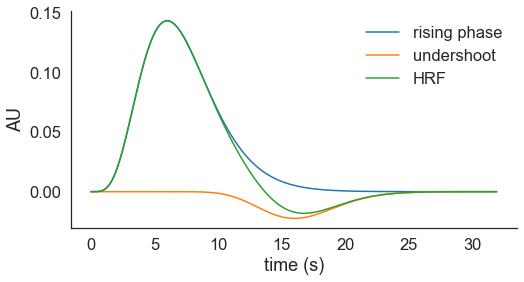

In [3]:
# Define time series
times = np.arange(0, 32, 0.1)

# Evaluate the PDF
rising = gamma_mode_pdf(times,  6, 3)
undershoot = -gamma_mode_pdf(times, 16, 3) / 6
hrf = rising + undershoot

# Plot both gammas and superposition
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(times, rising, label='rising phase')
ax.plot(times, undershoot, label='undershoot')
ax.plot(times, hrf, label='HRF')
ax.set(xlabel='time (s)', ylabel='AU')
ax.legend(loc=1, frameon=False)
sns.despine()

Now we have an HRF-like waveform. Early on in fMRI software, a common set of parameters was settled upon. In this class, we will call this the canonical HRF or the **SPM HRF**.

The SPM HRF has been conveniently programmed for you already. Importantly, the `spm_hrf` function requires the **repetition time (TR)** as an input. The TR is the sampling frequency of an fMRI experiment, or how often we acquire one complete image of the brain. The TR defines the smoothness of the idealized HRF. We'll start with an unrealistically high-resolution TR, but try more realistic values like `tr = 2.0`.

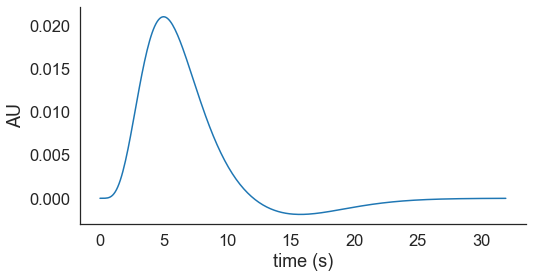

In [4]:
from fmritools.hrf import spm_hrf

# Define HRF with specified TR
tr = .1
hrf = spm_hrf(tr)
times = np.arange(0, 32, 32 / np.floor(32 / tr))

# Plot HRF
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(times, hrf)
ax.set(xlabel='time (s)', ylabel='AU')
sns.despine()

### Alternative HRFs
The (double gamma) SPM HRF is the default HRF in many neuroimaging studies. This is a particular assumption, and some ink has been spilled over when this assumption is valid. For today, we can explore the shape of a few other HRFs that have been discussed in the literature. This includes double-normal HRF and the inverse-logistic HRF.

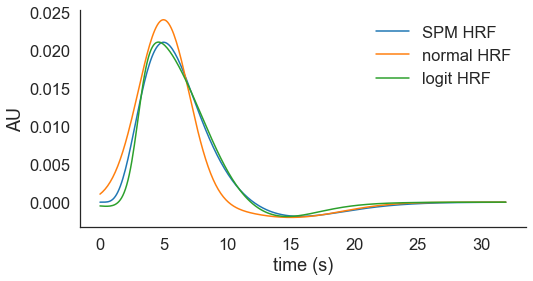

In [5]:
from fmritools.hrf import double_gaussian_hrf, inv_logit_hrf, double_gamma_hrf

# Plot several different HRF models
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(times, spm_hrf(0.1), label='SPM HRF')
ax.plot(times, double_gaussian_hrf(0.1), label='normal HRF')
ax.plot(times, inv_logit_hrf(0.1), label='logit HRF')
ax.legend(loc=1, frameon=False)
ax.set(xlabel='time (s)', ylabel='AU')
sns.despine()

One important point to add is that it is exceedingly rare for fMRI software packages to model the initial dip of the HRF.

### Exploring the impulse response
Putting aside the details of convolution for now, we can see how the HRF changes given different a different _impulse_. Here, an _impulse_ represents hypothetical neural activity occurring at a particular time with a particular duration (and magnitude). The HRF allows us to model the BOLD response resulting from the neural activity. We'll start by generating a very simple impulse.

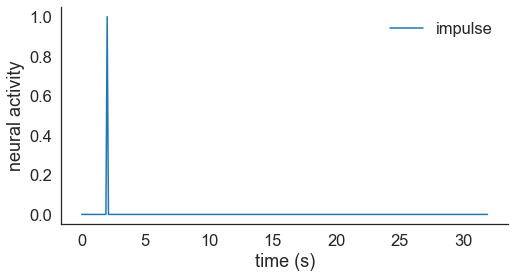

In [6]:
# Create 32-second long time window sampled at 10 Hz
n_times = 32
sfreq = 0.1
sst = np.arange(0, n_times, sfreq)

# Create a brief impulse and plot
onset = 2
duration = .1
magnitude = 1

impulse = np.zeros(sst.shape)
for t, o in enumerate(sst):
    if (o >= onset) and (o < onset + duration):
        impulse[t] = magnitude
        
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(sst, impulse, label='impulse')
ax.legend(loc=1, frameon=False)
ax.set(xlabel='time (s)', ylabel='neural activity')
sns.despine()

Let's briefly revisit the SPM HRF (without any explicit impulse):

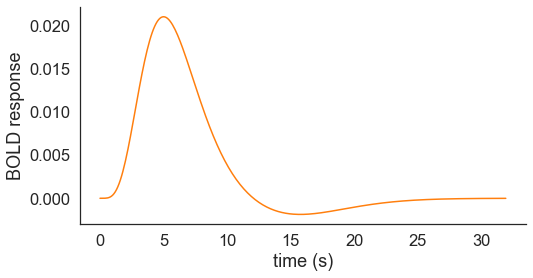

In [7]:
# Revisit our familiar HRF
hrf = spm_hrf(sfreq)
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(sst[:hrf.size], hrf, label='HRF', c='tab:orange')
ax.set(xlabel='time (s)', ylabel='BOLD response')
sns.despine()

Now, we can use _convolution_ (more on this in the next lesson!) to apply the HRF to impulse. This allows us to model the BOLD response to the given impulse representing neural activity. For simplicity, we'll normalize the heigh of the BOLD response to 1.

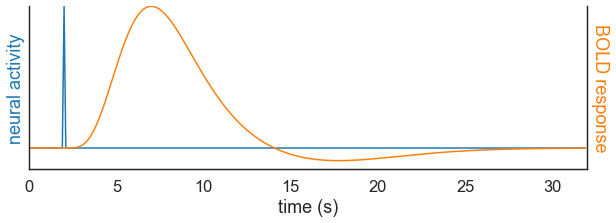

In [8]:
# Convolve impulse with HRF and plot
bold = np.convolve(impulse, hrf)[:sst.size]
bold /= bold.max()

fig, ax = plt.subplots(1, 1,figsize=(10, 3))
axt = ax.twinx()
ax.plot(sst, impulse, c='tab:blue')
ax.set(xlim=(0, n_times), ylim=(-.15, 1), xlabel='time (s)',
       yticks=[], ylabel='neural activity')
ax.yaxis.label.set_color('tab:blue')
axt.plot(sst, bold, c='tab:orange');
axt.set(xlim=(0, n_times), yticks=[], ylim=(-.15, 1))
axt.set_ylabel('BOLD response', rotation=270, va='bottom', )
axt.yaxis.label.set_color('tab:orange')
sns.despine(top=True, right=False)

Finally, we can wrap this up into a function to compute and plot the BOLD response to a given neural impulse. The first positional argument is the `onset` of the impulse, and the second positional argument is the `duration` of the impulse. Try re-running the function with impulses of different duration (e.g. 1.0s, 10.0s). You can also set `rescale=False` so that the BOLD response is not rescaled to unit magnitude. You'll see that longer-duration, higher-magnitude impulses yield longer-duration, higher-magnitude BOLD responses.

In [9]:
# Wrap this up into a function for convenience
def impulse_response(onset, duration, magnitude=1, rescale=True,
                     n_times=32, sfreq=0.1, hrf=spm_hrf):
    
    sst = np.arange(0, n_times, sfreq)
    impulse = np.zeros(sst.shape)
    for t, o in enumerate(sst):
        if (o >= onset) and (o < onset + duration):
            impulse[t] = magnitude

    hrf = spm_hrf(sfreq)
    bold = np.convolve(impulse, hrf)[:sst.size]
    
    if rescale:
        impulse /= impulse.max()
        bold /= bold.max()

    ylim = (np.amin(bold) - .1,
            np.amax(np.concatenate((impulse, bold)) + .1))
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    axt = ax.twinx()
    ax.plot(sst, impulse, c='tab:blue')
    ax.set(xlim=(0, n_times), ylim=ylim, xlabel='time (s)',
           yticks=[], ylabel='neural activity')
    ax.yaxis.label.set_color('tab:blue')
    axt.plot(sst, bold, c='tab:orange');
    axt.set(xlim=(0, n_times), yticks=[], ylim=ylim)
    axt.set_ylabel('BOLD response', rotation=270, va='bottom', )
    axt.yaxis.label.set_color('tab:orange')
    sns.despine(top=True, right=False)
    plt.show()

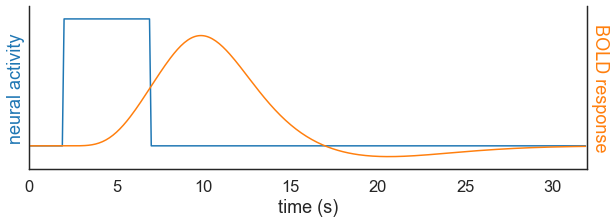

In [10]:
# Re-run this function with different onsets, durations, and magnitudes
impulse_response(2, 5, magnitude=1, rescale=False)

#### References

* Boynton, G. M., Engel, S. A., Glover, G. H., & Heeger, D. J. (1996). Linear systems analysis of functional magnetic resonance imaging in human V1. *Journal of Neuroscience*, *16*(13), 4207–4221. https://doi.org/10.1523/JNEUROSCI.16-13-04207.1996

* Cohen, M. S. (1997). Parametric analysis of fMRI data using linear systems methods. *NeuroImage*, *6*(2), 93–103. https://doi.org/10.1006/nimg.1997.0278

* Glover, G. H. (1999). Deconvolution of impulse response in event-related BOLD fMRI1. *NeuroImage*, *9*(4), 416–429. https://doi.org/10.1006/nimg.1998.0419

* Logothetis, N. K., Pauls, J., Augath, M., Trinath, T., & Oeltermann, A. (2001). Neurophysiological investigation of the basis of the fMRI signal. *Nature*, *412*(6843), 150–157. https://doi.org/10.1038/35084005